In [88]:
from create_table_fpdf2 import PDF

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tnorma import tnorma
from glob import glob
from pylab import rcParams
import os
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from detecta import detect_peaks
rcParams['figure.figsize'] = 12,4
rcParams['savefig.dpi'] = 300

logo_path = 'logo/'
now = datetime.now().strftime('%Y%m%d')

In [89]:
file_list = sorted(glob('data/**/**/process/*csv'))
fname = [os.path.basename(i).replace('.csv','') for i in file_list]
fname

['LeeKwangmin_right_20231225155644_90_185']

In [90]:
ks_cols = {
    'pelvis_rotational_velocity_with_respect_to_ground'  : ['Pelvic', 'r'],
    'trunk_rotational_velocity_with_respect_to_ground'   : ['Torso', 'g'],
    'lead_arm_rotational_velocity_with_respect_to_ground': ['Upper Arm','b'],
    'lead_shoulder_external_rotation_velocity'           : ['Shoulder', 'y'],
}

one_cols = {
    'trunk_twist_clockwise'           : 'X FACTOR',
    'trunk_lateral_flexion_right'     : 'TRUNK LATERAL TILT',
    'rear_shoulder_adduction'         : 'REAR SHOULDER AD-ABDUCTION',
    'lead_knee_extension'             : 'LEAD KNEE FLEXION-EXTENSION',
    'lead_knee_extension_velocity'    : 'LEAD KNEE EXTENSION ANGULAR VELOCITY',
    'lead_hip_flexion_with_respect_to_trunk' : 'LEAD HIP FLEXION-EXTENSION',
}

lead_cols= {
    'lead_shoulder_external_rotation' : ['SHOULDER', 'darkblue'],
    'lead_elbow_flexion'              : ['ELBOW'   , 'firebrick'],
}

In [91]:
file = file_list[0]
name = fname[0]

In [92]:
df= pd.read_csv(file)
time = df['time']
to_time = df['to_frame'].values[0]
kh_time = df['kh_frame'].values[0]
fc_time = df['fc_frame'].values[0]
bc_time = df['bc_frame'].values[0]

In [101]:
def kinematic_sequence(data, cols, time, to, kh, fc, bc):
    ks = {
        'max' : {},
        'time' : {},
    }
    fig, ax = plt.subplots()
    for col in cols:
        plt.plot(time, np.array(data[col]), color = cols[col][-1],label=cols[col][0])
        ks['max'][col] = round(data[col].max(),2)
        ks['time'][col] = np.where(data[col] == data[col].max())[0][0]
        plt.axvline(time[ks['time'][col]], color = cols[col][-1], linestyle = '--',alpha=0.7)

    plt.ylabel('Angular Velocity [Deg/s]')
    plt.xlabel('TIME [s]')
    plt.autoscale(axis='x', tight=True)
    plt.axvline(time[to], color='k',linestyle = '--',alpha=0.5)
    plt.axvline(time[kh], color='k',linestyle = '--',alpha=0.5)
    plt.axvline(time[fc], color='k',linestyle = '--',alpha=0.5)
    plt.axvline(time[bc], color='k',linestyle = '--',alpha=0.5)
    
    plt.axhline(0,color='k',lw=0.9)        
    
    plt.text(time[to+1],y = data['lead_shoulder_external_rotation_velocity'].max(), s='Toe Off',rotation = 90,verticalalignment='top',horizontalalignment='left')
    plt.text(time[kh+1],y = data['lead_shoulder_external_rotation_velocity'].max(), s='Knee High',rotation = 90,verticalalignment='top',horizontalalignment='left')
    plt.text(time[fc+1],y = data['lead_shoulder_external_rotation_velocity'].max(), s='Foot Contact',rotation = 90,verticalalignment='top',horizontalalignment='left')
    plt.text(time[bc+1],y = data['lead_shoulder_external_rotation_velocity'].max(), s='Ball Contact', rotation=90,verticalalignment='top',horizontalalignment='left')
    plt.title(f"KINEMATIC SEQUENCE")
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(axis='y')
    plt.tight_layout()
    plt.legend()
    plt.savefig(f"figure/KINEMATIC SEQUENCE.png", dpi=300, bbox_inches="tight")
    
    return ks

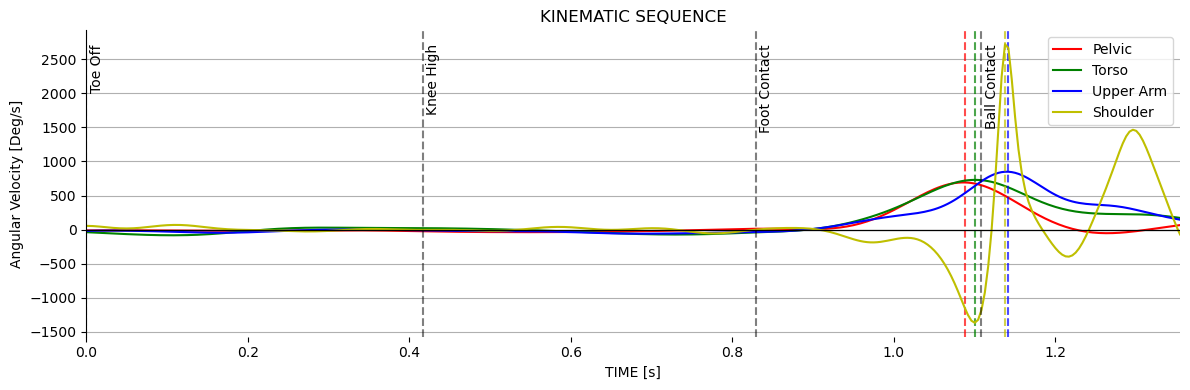

In [102]:
ks = kinematic_sequence(df, ks_cols,time, to_time, kh_time, fc_time, bc_time)

In [111]:
def one_angle(data, cols, time, to_time, kh_time, fc_time, bc_time):
    ang = {
        'to_time'  : {},
        'kh_time'  : {},
        'fc_time'  : {},
        'bc_time'  : {},
        'max'      : {},
        'max_time' : {},
        'min'      : {},
        'min_time' : {},
    }
    
    for col in cols:
        fig, ax = plt.subplots()
        plt.plot(time, np.array(data[col]),color = 'firebrick')
        ang['to_time'][col] = round(data[col][to_time], 2)
        ang['kh_time'][col] = round(data[col][kh_time], 2)
        ang['fc_time'][col] = round(data[col][fc_time], 2)
        ang['bc_time'][col] = round(data[col][bc_time], 2)
        ang['max'][col] = round(data[col].iloc[fc_time:bc_time+1].max(),2)
        ang['min'][col] = round(data[col].iloc[fc_time:bc_time+1].min(),2)
        ang['max_time'][col] = np.where(data[col] == data[col].iloc[fc_time:bc_time+1].max())
        ang['min_time'][col] = np.where(data[col] == data[col].iloc[fc_time:bc_time+1].min())
            
        m = data[col].max()
        
        if 'velocity' in col:
            ylb = 'Angular Velocity [deg/s]'
        else:
            ylb = 'Angle [deg]'
            
        plt.ylabel(ylb)
        plt.xlabel('Time [s]')
        plt.autoscale(axis='x', tight=True)
        plt.axvline(time[to_time], color='k',linestyle = '--',alpha=0.5)
        plt.axvline(time[kh_time], color='k',linestyle = '--',alpha=0.5)
        plt.axvline(time[fc_time], color='k',linestyle = '--',alpha=0.5)
        plt.axvline(time[bc_time], color='k',linestyle = '--',alpha=0.5)
        
        plt.axhline(0,color='k',lw=0.9)  
        plt.text(time[to_time+1],y = m, s='Toe Off',rotation = 90,verticalalignment='top',horizontalalignment='left')
        plt.text(time[kh_time+1],y = m, s='Knee High',rotation = 90,verticalalignment='top',horizontalalignment='left')
        plt.text(time[fc_time+1],y = m, s='Foot Contact',rotation = 90,verticalalignment='top',horizontalalignment='left')
        plt.text(time[bc_time+1], y = m,s='Ball Contact', rotation=90,verticalalignment='top',horizontalalignment='left')
        # plt.legend()
        plt.tight_layout()
        plt.title(f'{cols[col]}')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.grid(axis='y')
        plt.savefig(f"figure/{cols[col]}.png", dpi=300, bbox_inches='tight')
        plt.show()
    
    return ang

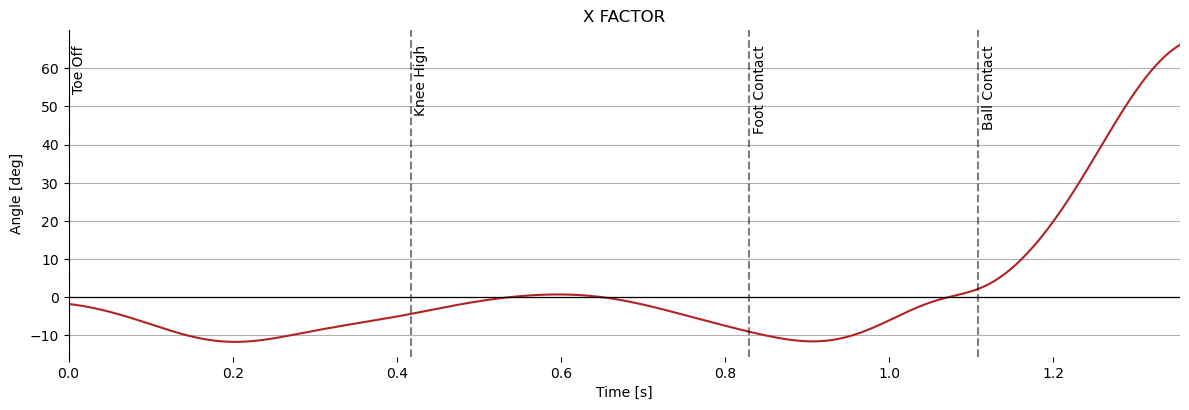

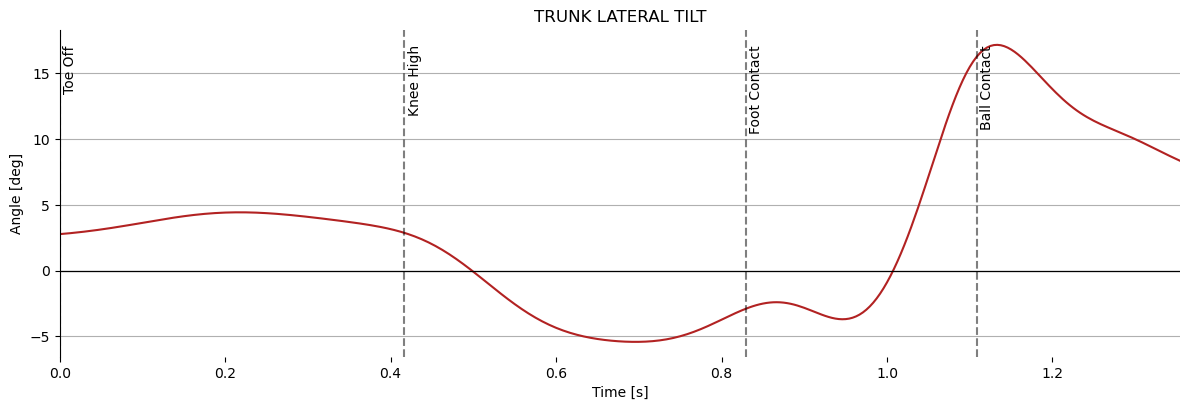

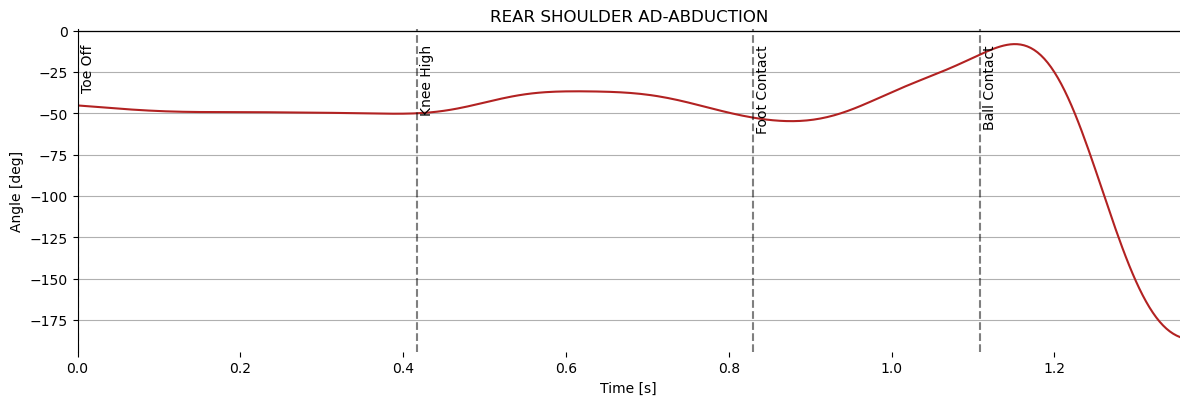

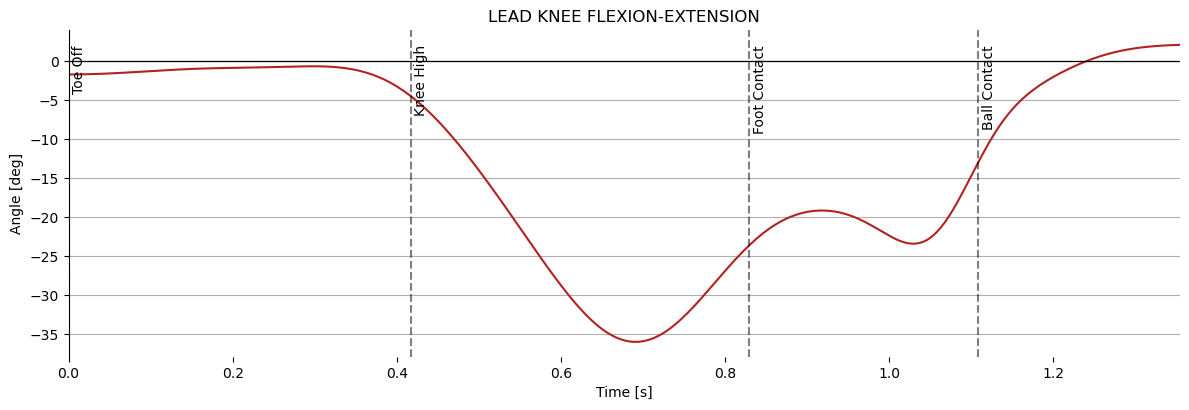

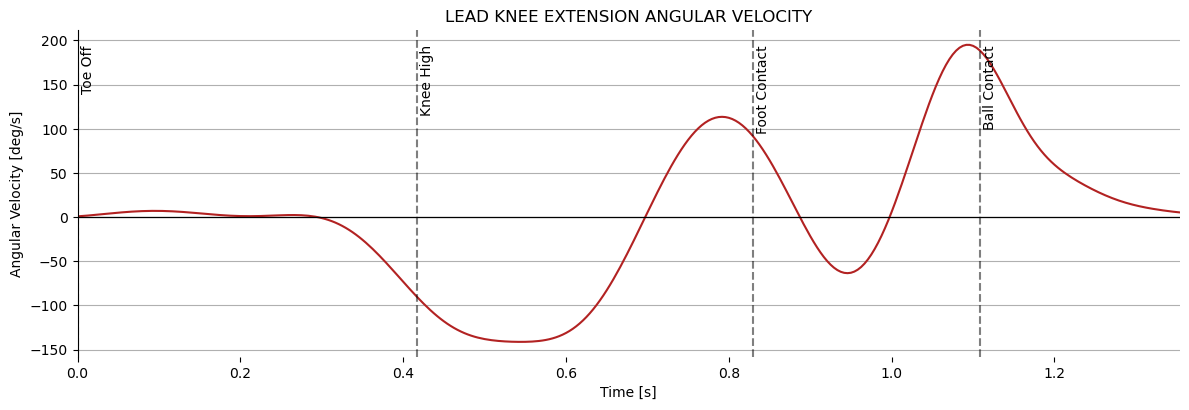

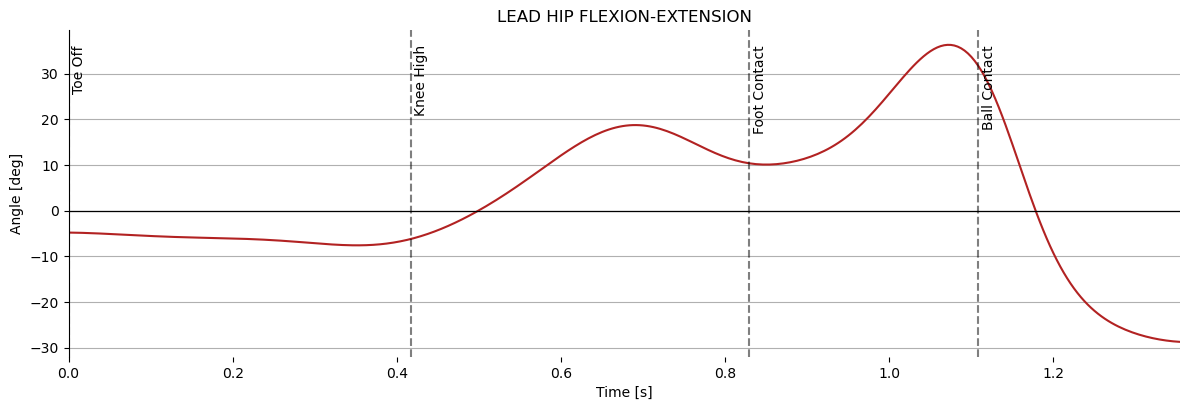

In [112]:
ang = one_angle(df, one_cols, time, to_time, kh_time, fc_time, bc_time)

In [115]:
def lead_arm(data, cols, time, to_time, kh_time, fc_time, bc_time):
    arm = {
        'to_time' : {},
        'kh_time' : {},
        'fc_time' : {},
        'bc_time' : {},
        'max'     : {},
        'max_time': {},
        'min'     : {},
        'min_time': {}
        }
    fig, ax = plt.subplots()
    for col in cols:
        plt.plot(time, np.array(data[col]),color = cols[col][-1],label=cols[col][0])
        arm['to_time'][col] = round(data[col][to_time], 2)
        arm['kh_time'][col] = round(data[col][kh_time], 2)
        arm['fc_time'][col] = round(data[col][fc_time], 2)
        arm['bc_time'][col] = round(data[col][bc_time], 2)
        arm['max'][col] = round(data[col].iloc[fc_time:bc_time+1].max(), 2)
        arm['max_time'][col] = np.where(data[col] == data[col].iloc[fc_time:bc_time+1].max())
        arm['min'][col] = round(data[col].iloc[fc_time:bc_time+1].min(), 2)
        arm['min_time'][col] = np.where(data[col] == data[col].iloc[fc_time:bc_time+1].min())
    
    m = data[cols.keys()].max().max()
    
    plt.ylabel('Angle [Deg]')
    plt.xlabel('Time [s]')
    plt.autoscale(axis='x', tight=True)
    plt.axvline(time[to_time], color='k',linestyle = '--',alpha=0.5)
    plt.axvline(time[kh_time], color='k',linestyle = '--',alpha=0.5)
    plt.axvline(time[fc_time], color='k',linestyle = '--',alpha=0.5)
    plt.axvline(time[bc_time], color='k',linestyle = '--',alpha=0.5)
    
    plt.axhline(0,color='k',lw=0.9)
    plt.text(time[to_time],y = m, s='Toe Off',rotation = 90,verticalalignment='top',horizontalalignment='left')
    plt.text(time[kh_time],y = m, s='Knee High',rotation = 90,verticalalignment='top',horizontalalignment='left')
    plt.text(time[fc_time],y = m, s='Foot Contact',rotation = 90,verticalalignment='top',horizontalalignment='left')
    plt.text(time[bc_time], y = m,s='Ball Contact', rotation=90,verticalalignment='top',horizontalalignment='left')
    plt.legend()
    plt.tight_layout()
    plt.title('PELVIC ANGLE')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(axis='y')
    plt.savefig(f"figure/Lead Arm.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return arm